In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from xml.etree import ElementTree as ET
from prop_eval import mabo
from prop_eval import detection_rate

In [2]:
# speed-up using multithreads
cv2.setUseOptimized(True)
cv2.setNumThreads(4)

def selective_search(image_path, num_rects):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    image = cv2.imread(image_path)
    ss.setBaseImage(image)
    
    #ss.switchToSelectiveSearchFast()
    ss.switchToSelectiveSearchQuality()
    rects = ss.process()

    return rects[:num_rects]

def show_selective_search(image, rects):
    imOut = image.copy()

    # itereate over all the region proposals
    for _, rect in enumerate(rects):
        # draw rectangle for region proposal
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)

    plt.imshow(imOut[...,::-1])
    plt.axis('off')

In [3]:
from xml.etree import ElementTree as ET

def read_xml(path: str) -> list:  

    tree = ET.parse(path)
    root = tree.getroot()

    obj_list = []

    for obj in root.iter('object'):

        ymin = int(obj.find("bndbox/ymin").text)
        xmin = int(obj.find("bndbox/xmin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        xmax = int(obj.find("bndbox/xmax").text)

        bbox = (xmin, ymin, xmax, ymax)
        obj_list.append(bbox)
    
    return obj_list

In [4]:
image_path = 'Potholes/annotated-images/img-1.jpg'

GT = read_xml(image_path.replace("jpg", "xml"))

mabo_result = []
recall_result = []
step = 20
boxes = np.arange(step, step * 100 + 1, step)
iou_k = 0.7

for box in boxes:
    rects = selective_search(image_path, box)
    mabo_result.append(mabo(rects, GT, coord = 'xywh'))
    recall_result.append(detection_rate(rects, GT, iou_k, coord = 'xywh'))

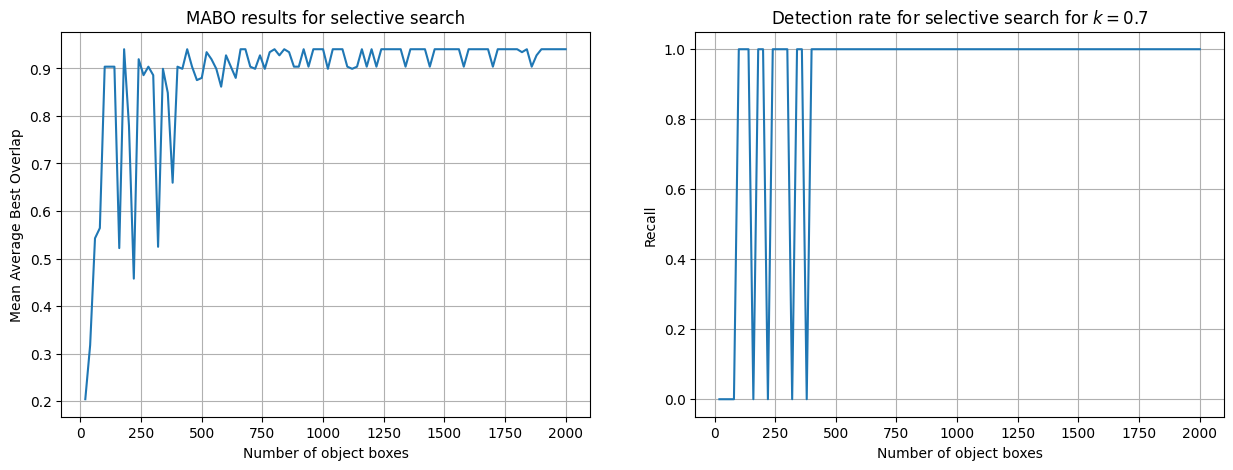

In [5]:
fig, ax = plt. subplots(1, 2)

ax[0].plot(boxes, mabo_result)
ax[0].set_xlabel("Number of object boxes")
ax[0].set_ylabel("Mean Average Best Overlap")
ax[0].set_title("MABO results for selective search")
ax[0].grid()

ax[1].plot(boxes, recall_result)
ax[1].set_xlabel("Number of object boxes")
ax[1].set_ylabel("Recall")
ax[1].set_title(rf"Detection rate for selective search for $k = {iou_k}$")
ax[1].grid()

fig.set_figheight(5)
fig.set_figwidth(15)

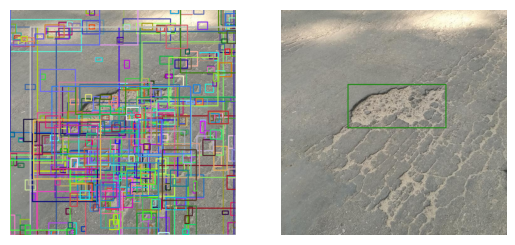

In [6]:
plt.subplot(1, 2, 1)
rects = selective_search(image_path, 500)
show_selective_search(cv2.imread(image_path), rects)

plt.subplot(1, 2, 2)
im_GT = np.array(GT)
im_GT[:, 2] = im_GT[:, 2] - im_GT[:, 0]
im_GT[:, 3] = im_GT[:, 3] - im_GT[:, 1]
show_selective_search(cv2.imread(image_path), im_GT)